# New York City Bus Ride Duration Prediction 
--------
## Objective
- To Build a predictive model, for predicting the duration for the bus ride. 
- Use Automated feature engineering to create new features
---------------
## Dataset
The **trips** table has the following fields
* **id** which uniquely identifies the trip
* **Transport_Service** is the transport company - in our case study we have data from 4 different transport companies
* **pickup_datetime** the time stamp for pickup
* **dropoff_datetime** the time stamp for drop-off
* **passenger_count** the number of passengers for the trip
* **trip_distance** total distance of the trip in miles 
* **pickup_longitude** the longitude for pickup
* **pickup_latitude** the latitude for pickup
* **dropoff_longitude**the longitude of dropoff 
* **dropoff_latitude** the latitude of dropoff
* **payment_type** a numeric code signifying how the passenger paid for the trip. 1= Credit card 2= Cash 3= Unknown
* **trip_duration** this is the duration we would like to predict using other fields 
* **pickup_neighborhood** a one or two letter id of the neighborhod where the trip started
* **dropoff_neighborhood** a one or two letter id of the neighborhod where the trip ended

In [1]:
# installing featuretools library
!pip install featuretools==0.27.0

In [2]:
# importing necessary libraries

# Data Manipulation and Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering
import featuretools as ft

# Primitives for Feature Engineering
from featuretools.primitives import (Minute, Hour, Day, Month, Weekday, IsWeekend, Count, Sum, Mean, Median, Std, Min, Max)

# Model building
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
# necessary functions 
def preview(df, n=5):
    """ Return n rows that have fewest number of nulls """
    order = df.isnull().sum(axis=1).sort_values().head(n).index
    return df.loc[order]

def feature_importances(model, feature_names, n=10):
    importances = model.feature_importances_
    zipped = sorted(zip(feature_names, importances), key=lambda x: -x[1])
    for i, f in enumerate(zipped[:n]):
        print(f'{i+1}d: Feature: {f[0]}s, {f[1]}.3f')
        
def get_train_test_fm(feature_matrix, percentage):
    nrows = feature_matrix.shape[0]
    head = int(nrows * percentage)
    tail = nrows - head
    X_train = feature_matrix.head(head)
    y_train = X_train['trip_duration']
    X_train = X_train.drop(['trip_duration'], axis=1)
    imp = SimpleImputer()
    X_train = imp.fit_transform(X_train)
    X_test = feature_matrix.tail(tail)
    y_test = X_test['trip_duration']
    X_test = X_test.drop(['trip_duration'], axis=1)
    X_test = imp.transform(X_test)
    
    return (X_train, y_train, X_test, y_test)

def column_string(n):
    string = ''
    while n > 0:
        n, remainder = divmod(n-1, 26)
        string = chr(65 + remainder) + string
    return string

def load_nyc_BUS_data():
    trips = pd.read_csv('BUS_SERVICE.csv',
                        parse_dates=['pickup_datetime','dropoff_datetime'],
                        dtype={'vendor_id':'category', 'passenger_count':'int64'},
                        encoding='utf-8')
    trips['payment_type'] = trips['payment_type'].apply(str)
    trips = trips.dropna(axis=0, how='any', subset=['trip_duration'])
    
    pickup_neighborhoods = pd.read_csv('pickup_neighborhoods-1.csv', encoding='utf-8')
    dropoff_neighborhoods = pd.read_csv('dropoff_neighborhoods-1.csv', encoding='utf-8')
    
    return trips, pickup_neighborhoods, dropoff_neighborhoods

def compute_features(features, cutoff_time):
    np.random.shuffle(features) # shuffle se we don't see encoded features in the front or back
    feature_matrix = ft.calculate_feature_matrix(features,
                                                 cutoff_time='36d',
                                                 verbose=True)
    print('Finishing computing...')
    feature_matrix, features = ft.encode_features(feature_matrix, features, 
                                                  to_encode=['pickup_neighborhood', 'dropoff_neighborhood'],
                                                  include_unknown=False)
    return feature_matrix

In [4]:
# loading the dataset
trips, pickup_neighborhoods, dropoff_neighborhoods = load_nyc_BUS_data()
preview(trips,10)

,id,Transport_service,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,0,3,2019-01-01 00:00:00,2019-01-01 00:06:00,1,1.32,-73.961258,40.796200,-73.950050,40.787312,3,387,AH,C
997,997,4,2019-01-01 02:38:00,2019-01-01 02:52:00,3,5.57,-73.952347,40.824081,-73.996429,40.759918,1,828,AL,P
996,996,4,2019-01-01 02:38:00,2019-01-01 02:41:00,2,0.20,-73.980171,40.745308,-73.984192,40.745892,2,184,Y,AO
995,995,3,2019-01-01 02:38:00,2019-01-01 02:52:00,1,2.83,-73.991966,40.759331,-74.004707,40.724442,2,815,P,AB
994,994,2,2019-01-01 02:38:00,2019-01-01 02:49:00,2,2.48,-73.961441,40.694302,-73.959938,40.662540,1,655,V,AF
993,993,3,2019-01-01 02:38:00,2019-01-01 02:40:00,4,0.72,-73.974014,40.782967,-73.969894,40.788155,2,162,I,U
992,992,2,2019-01-01 02:38:00,2019-01-01 03:13:00,3,10.50,-73.956985,40.766346,-73.966179,40.674366,3,2131,K,V
991,991,4,2019-01-01 02:38:00,2019-01-01 02:52:00,3,6.80,-73.911682,40.775295,-73.903908,40.817696,2,898,W,S
990,990,1,2019-01-01 02:38:00,2019-01-01 03:22:00,1,13.80,-73.976143,40.775990,-73.940956,40.676426,2,2693,AV,AW
989,989,2,2019-01-01 02:38:00,2019-01-01 03:08:00,1,9.00,-73.981331,40.780663,-73.848824,40.722755,3,1841,AV,B


In [5]:
# dropping nulls from trips dataset
trips = trips.dropna()

In [6]:
# first five rows of trips
trips.head()

,id,Transport_service,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,0,3,2019-01-01 00:00:00,2019-01-01 00:06:00,1,1.32,-73.961258,40.796200,-73.950050,40.787312,3,387,AH,C
1,1,1,2019-01-01 00:01:00,2019-01-01 00:27:00,3,13.70,-73.956169,40.707756,-73.939949,40.839558,3,1568,Z,S
2,2,4,2019-01-01 00:01:00,2019-01-01 00:21:00,1,5.30,-73.993103,40.752632,-73.953903,40.816540,1,1219,D,AL
3,3,2,2019-01-01 00:01:00,2019-01-01 00:16:00,2,7.19,-73.983009,40.731419,-73.930969,40.808460,2,873,AT,J
4,4,1,2019-01-01 00:02:00,2019-01-01 00:20:00,2,2.90,-74.004631,40.747234,-73.976395,40.777237,1,1091,AG,AV


In [7]:
# info of the dataset
trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1452 entries, 0 to 1499
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    1452 non-null   int64         
 1   Transport_service     1452 non-null   int64         
 2   pickup_datetime       1452 non-null   datetime64[ns]
 3   dropoff_datetime      1452 non-null   datetime64[ns]
 4   passenger_count       1452 non-null   int64         
 5   trip_distance         1452 non-null   float64       
 6   pickup_longitude      1452 non-null   float64       
 7   pickup_latitude       1452 non-null   float64       
 8   dropoff_longitude     1452 non-null   float64       
 9   dropoff_latitude      1452 non-null   float64       
 10  payment_type          1452 non-null   object        
 11  trip_duration         1452 non-null   int64         
 12  pickup_neighborhood   1452 non-null   object        
 13  dropoff_neighborho

In [8]:
# unique values in each column
trips.nunique()

id                      1452
Transport_service          4
pickup_datetime          259
dropoff_datetime         274
passenger_count            4
trip_distance            531
pickup_longitude        1338
pickup_latitude         1418
dropoff_longitude       1331
dropoff_latitude        1416
payment_type               3
trip_duration            969
pickup_neighborhood       47
dropoff_neighborhood      49
dtype: int64

In [9]:
# summary statistics
trips.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1452.0,749.218320,434.555493,0.000000,369.750000,749.500000,1125.250000,1499.000000
Transport_service,1452.0,2.488292,1.123890,1.000000,1.000000,2.000000,4.000000,4.000000
passenger_count,1452.0,2.506198,1.111603,1.000000,2.000000,2.000000,4.000000,4.000000
trip_distance,1452.0,3.173320,2.798477,0.000000,1.300000,2.250000,4.260000,17.990000
pickup_longitude,1452.0,-73.973295,0.025778,-74.017311,-73.989311,-73.979614,-73.961092,-73.781807
pickup_latitude,1452.0,40.750311,0.029513,40.638889,40.733079,40.751900,40.768478,40.847500
dropoff_longitude,1452.0,-73.965157,0.034889,-74.024834,-73.988117,-73.974369,-73.950407,-73.770943
dropoff_latitude,1452.0,40.750691,0.038322,40.633560,40.729924,40.751728,40.774967,40.848629
trip_duration,1452.0,828.261019,528.279643,18.000000,428.000000,708.000000,1116.500000,3201.000000


In [10]:
# checking rows where the trip_distance is 0
trips[trips.trip_distance == 0]

,id,Transport_service,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
880,880,2,2019-01-01 02:15:00,2019-01-01 02:16:00,4,0.0,-74.002586,40.750298,-74.002861,40.750446,2,36,AG,AG
1116,1116,1,2019-01-01 03:01:00,2019-01-01 03:03:00,1,0.0,-73.987831,40.728558,-73.988747,40.727280,3,151,H,H
1455,1455,1,2019-01-01 04:09:00,2019-01-01 04:10:00,1,0.0,-73.985893,40.763649,-73.985741,40.763672,2,80,AR,AR
1488,1488,2,2019-01-01 04:16:00,2019-01-01 04:16:00,3,0.0,-74.014198,40.709988,-74.014198,40.709988,2,18,AU,AU


In [11]:
# replacing the 0 values with median of the trip distance
trips['trip_distance'] = trips['trip_distance'].replace(0, trips['trip_distance'].median())
trips[trips['trip_distance'] == 0].count()

id                      0
Transport_service       0
pickup_datetime         0
dropoff_datetime        0
passenger_count         0
trip_distance           0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
payment_type            0
trip_duration           0
pickup_neighborhood     0
dropoff_neighborhood    0
dtype: int64

## Exploratory Data Analysis (EDA)
### Univariate Analysis

id


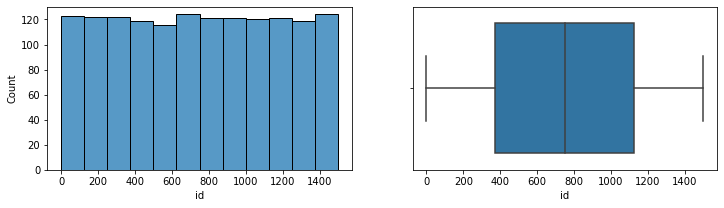

Transport_service


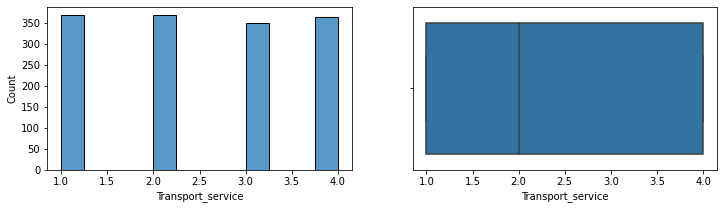

passenger_count


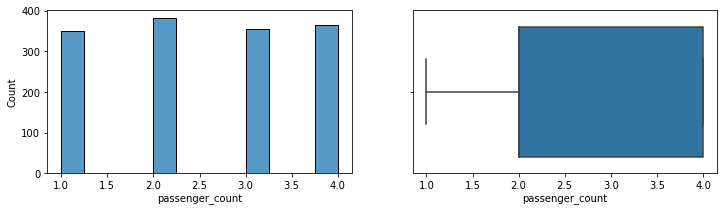

trip_distance


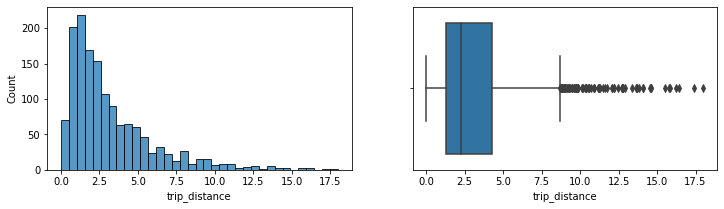

pickup_longitude


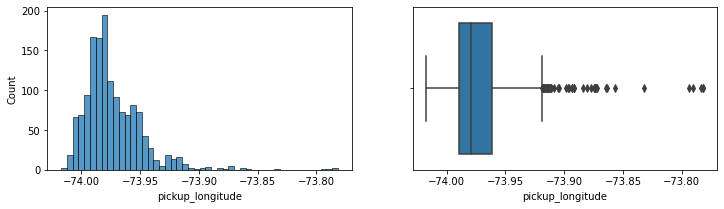

pickup_latitude


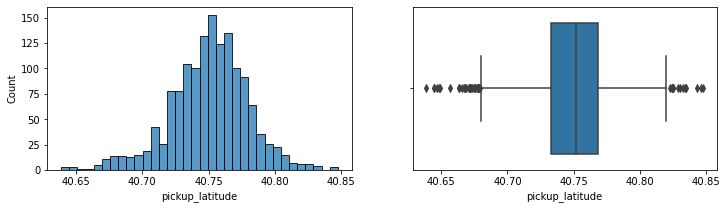

dropoff_longitude


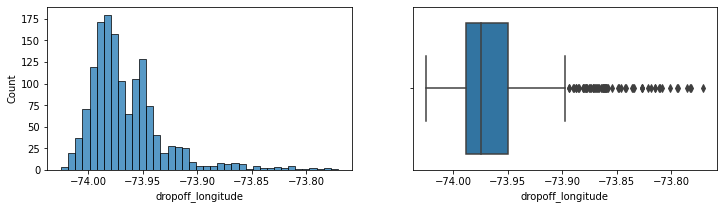

dropoff_latitude


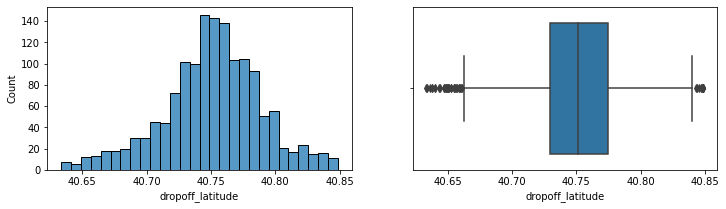

trip_duration


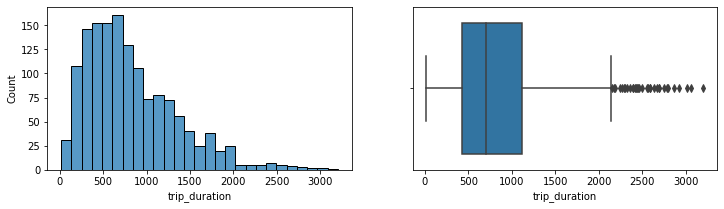

In [12]:
# separating numerical and categorical columns
trips_num = trips.select_dtypes(include=['int64','float64'])
trips_cat = trips.select_dtypes(include=['object'])

# plotting histogram and boxplot for every numerical column
for col in trips_num.columns:
    print(col)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,3))
    sns.histplot(x=col, data=trips_num, ax=ax1)
    sns.boxplot(x=col, data=trips_num, ax=ax2)
    plt.show()

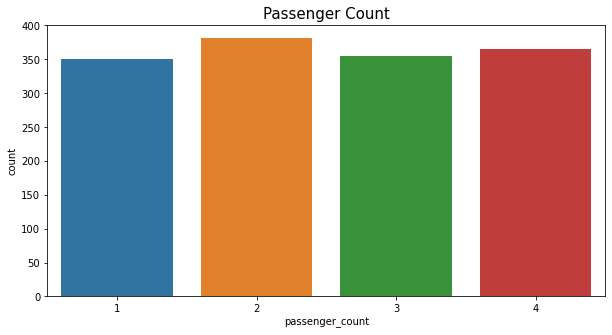

In [13]:
# countplot for passenger count
plt.figure(figsize=(10,5))
sns.countplot(x='passenger_count', data=trips)
plt.title('Passenger Count', size=15)
plt.show()

In [14]:
trips.passenger_count.value_counts(normalize=True)

2    0.263085
4    0.251377
3    0.244490
1    0.241047
Name: passenger_count, dtype: float64

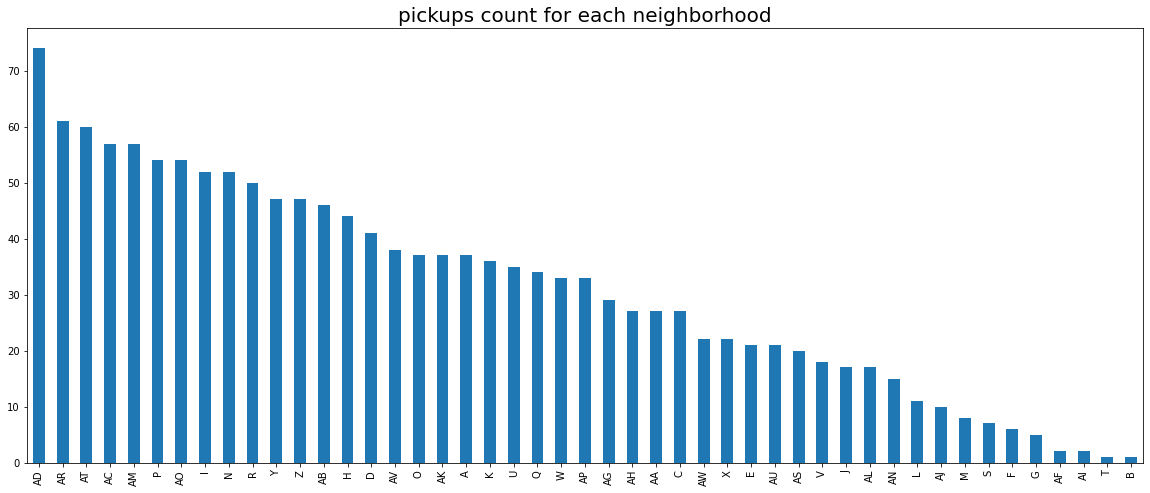

In [15]:
# countplot for pickup and dropoff neighborhood
trips.pickup_neighborhood.value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(20,8))
plt.title('pickups count for each neighborhood', size=20)
plt.show()


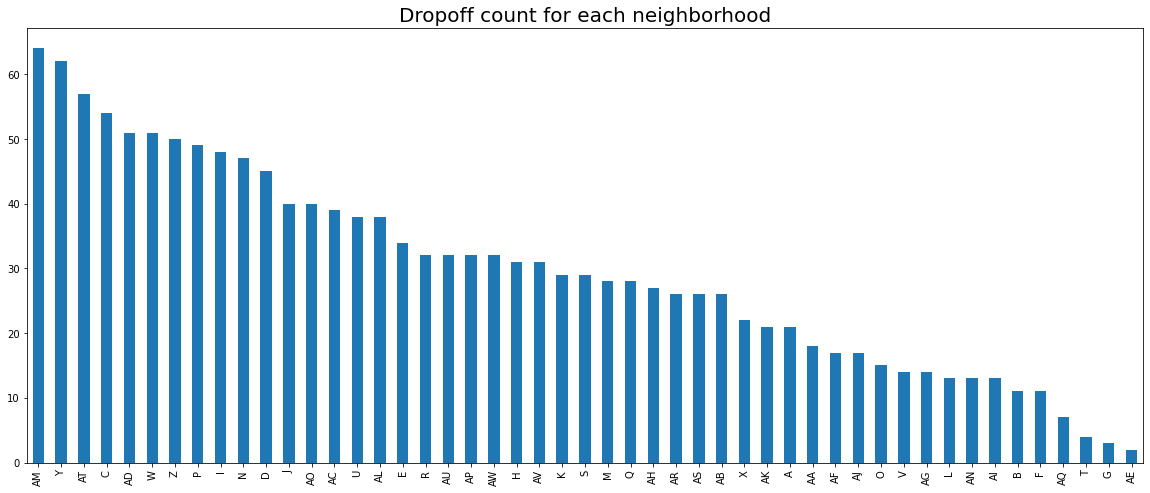

In [16]:
trips.dropoff_neighborhood.value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(20,8))
plt.title('Dropoff count for each neighborhood', size=20)
plt.show()

### Bivariate Analysis

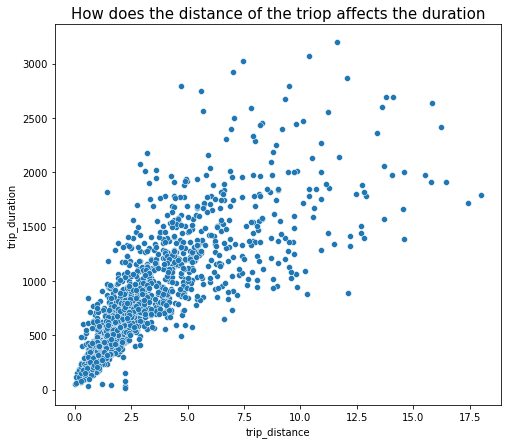

In [17]:
# scatter plot for trip distance and duration
plt.figure(figsize=(8,7))
sns.scatterplot(x='trip_distance', y='trip_duration', data=trips)
plt.title('How does the distance of the triop affects the duration', size=15)
plt.show()

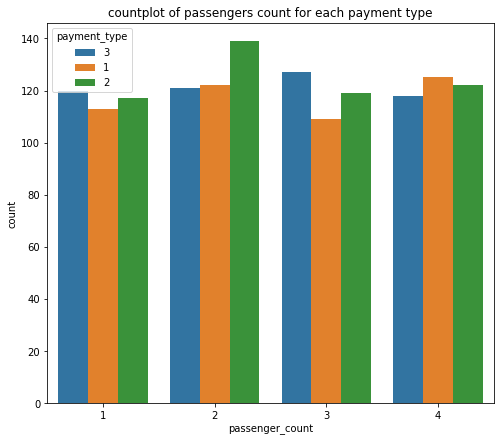

In [18]:
# countplot of passenger count for each payment type
plt.figure(figsize=(8,7))
sns.countplot(x='passenger_count', hue='payment_type', data=trips)
plt.title('countplot of passengers count for each payment type')
plt.show()

### Data Preparation

### Step 2: Prepare the Data

The three entities in this data are 
* trips 
* pickup_neighborhoods
* dropoff_neighborhoods

This data has the following relationships
* pickup_neighborhoods --> trips (one neighborhood can have multiple trips that start in it. This means pickup_neighborhoods is the ``parent_entity`` and trips is the child entity)
* dropoff_neighborhoods --> trips (one neighborhood can have multiple trips that end in it. This means dropoff_neighborhoods is the ``parent_entity`` and trips is the child entity)

In [19]:
entities = {
        "trips": (trips, "id", 'pickup_datetime' ),
        "pickup_neighborhoods": (pickup_neighborhoods, "neighborhood_id"),
        "dropoff_neighborhoods": (dropoff_neighborhoods, "neighborhood_id"),
        }

relationships = [("pickup_neighborhoods", "neighborhood_id", "trips", "pickup_neighborhood"),
                 ("dropoff_neighborhoods", "neighborhood_id", "trips", "dropoff_neighborhood")]

Next, we specify the cutoff time for each instance of the target_entity, in this case ``trips``.This timestamp represents the last time data can be used for calculating features by DFS. In this scenario, that would be the pickup time because we would like to make the duration prediction using data before the trip starts. 

For the purposes of the case study, we choose to only select trips that started after January 12th, 2016. 

In [20]:
cutoff_time = trips[['id', 'pickup_datetime']]
preview(cutoff_time, 10)

,id,pickup_datetime
0,0,2019-01-01 00:00:00
1004,1004,2019-01-01 02:39:00
1003,1003,2019-01-01 02:39:00
1002,1002,2019-01-01 02:39:00
1001,1001,2019-01-01 02:39:00
1000,1000,2019-01-01 02:39:00
999,999,2019-01-01 02:39:00
998,998,2019-01-01 02:39:00
997,997,2019-01-01 02:38:00
1005,1005,2019-01-01 02:39:00


### Creating baseline features using Deep Feature Sysnthesis

**baseline model with only 1 transform primitive**

In [21]:
trans_primitives = [IsWeekend]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [22]:
print('Number of features: {}'.format(len(features)))
features

Number of features: 13


[<Feature: Transport_service>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

In [23]:
def compute_features(features, cutoff_time):
    # shuffle so we don't see encoded features in the front or backs

    np.random.shuffle(features)
    feature_matrix = ft.calculate_feature_matrix(features,
                                                 cutoff_time=cutoff_time,
                                                 approximate='36d',
                                                 verbose=True,entities=entities, relationships=relationships)
    print("Finishing computing...")
    feature_matrix, features = ft.encode_features(feature_matrix, features,
                                                  to_encode=["pickup_neighborhood", "dropoff_neighborhood"],
                                                  include_unknown=False)
    return feature_matrix

In [24]:
feature_matrix1 = compute_features(features, cutoff_time)

Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
Finishing computing...


In [25]:
preview(feature_matrix1, 5)

,IS_WEEKEND(dropoff_datetime),dropoff_neighborhood = AM,dropoff_neighborhood = Y,dropoff_neighborhood = AT,dropoff_neighborhood = C,dropoff_neighborhood = W,dropoff_neighborhood = AD,dropoff_neighborhood = Z,dropoff_neighborhood = P,dropoff_neighborhood = I,...,pickup_neighborhood = AC,pickup_neighborhood = P,pickup_neighborhood = AO,pickup_neighborhood = N,pickup_neighborhood = I,pickup_neighborhood = R,payment_type,pickup_neighborhoods.longitude,dropoff_neighborhoods.latitude,passenger_count
id,,,,,,,,,,,,,,,,,,,,,
0,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,3,-73.961716,40.783780,1
1004,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,1,-73.919159,40.766575,1
1003,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,1,-73.954298,40.715828,4
1002,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,2,-73.981693,40.775357,3
1001,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,2,-73.998366,40.793597,3


In [26]:
feature_matrix1.shape

(1452, 31)

## Model building

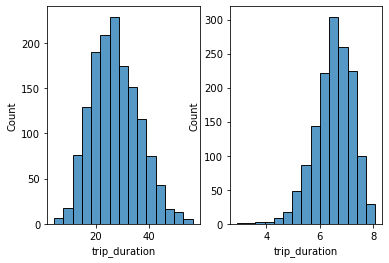

In [27]:
# applying sqrt and log in trip_duration column
fig, (ax1, ax2) = plt.subplots(1,2)
sns.histplot(x=np.sqrt(trips.trip_duration), bins=15, ax=ax1)
sns.histplot(x=np.log(trips.trip_duration), bins=15, ax=ax2)
plt.show()

- easy to see that the sqrt transformation is closer from a normal distribution, so i'll chose this one. 

In [28]:
# splitting the data
X_train, y_train, X_test, y_test = get_train_test_fm(feature_matrix1, .75)
y_train = np.sqrt(y_train)
y_test = np.sqrt(y_test)

In [29]:
# model performance function
def rmse(predictions, targets):
    return np.sqrt(((targets - predictions)**2).mean())

def mae(predictions, targets):
    return np.mean(np.abs((targets - predictions)))

def model_pref(model, x_train, x_test, y_train, y_test):
    # insample prediction
    y_pred_train = model.predict(x_train)
    y_observed_train = y_train
    
    # test data prediction
    y_pred_test = model.predict(x_test)
    y_observed_test = y_test
    
    display(
        pd.DataFrame(
            {
                'Data':['train', 'test'],
                'RSquared':[r2_score(y_observed_train, y_pred_train),
                            r2_score(y_observed_test, y_pred_test)],
                'RMSE':[rmse(y_pred_train, y_observed_train),
                        rmse(y_pred_test, y_observed_test)],
                'MAE':[mae(y_pred_train, y_observed_train),
                       mae(y_pred_test, y_observed_test)]
            }
        )
    )
    

In [30]:
# liner regression model
lr1 = LinearRegression()
lr1.fit(X_train, y_train)
model_pref(lr1, X_train, X_test, y_train, y_test)

,Data,RSquared,RMSE,MAE
0,train,0.662819,5.246785,4.052007
1,test,0.583352,5.583601,4.172844


- Model is giving only 0.58 Rsquared, with RSME of 5.58 and MAE of ~4.17.
- Model is slightly overfitting.

In [31]:
# decision tree model
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
model_pref(dt, X_train, X_test, y_train, y_test)

,Data,RSquared,RMSE,MAE
0,train,1.000000,0.000000,0.00000
1,test,0.483239,6.218341,4.77169


**Write your answers here:_____**
- The model is overfitting a lot, with train R2 as 1 while test R2 as 0.49
- This generally happens in decision tree, one solution for this is to Prune the decision tree, let's try pruning and see if the performance improves. 

In [32]:
# pruned decision tree 
dt_pruned = DecisionTreeRegressor(max_depth=3)
dt_pruned.fit(X_train, y_train)
model_pref(dt_pruned, X_train, X_test, y_train, y_test)

,Data,RSquared,RMSE,MAE
0,train,0.748675,4.529805,3.404459
1,test,0.681276,4.883566,3.780489


- The pruned model is performing better that both baseline decision tree and linear regression, with R2 as ~.68.

In [33]:
# random forest regressor
rf=RandomForestRegressor(n_estimators=60, max_depth=4)
rf.fit(X_train, y_train)
model_pref(rf, X_train, X_test, y_train, y_test)

,Data,RSquared,RMSE,MAE
0,train,0.811067,3.927496,2.900883
1,test,0.732965,4.470065,3.522444


**Write your answers here:_____**
- The score for the model with only 1 transform primitive is ~74%. 
- This model is performing little better than pruned decision tree model.
- Model is slightly overfitting.

## Adding more tranform primitives

In [34]:
trans_primitives = [Minute, Hour, Day, Month, Weekday, IsWeekend]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [35]:
print('Number of features {}'.format(len(features)))
features

Number of features 23


[<Feature: Transport_service>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

In [36]:
feature_matrix2 = compute_features(features, cutoff_time)

Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
Finishing computing...


In [37]:
feature_matrix2.shape

(1452, 41)

In [38]:
feature_matrix2.head()

,DAY(pickup_datetime),MINUTE(pickup_datetime),MONTH(dropoff_datetime),HOUR(pickup_datetime),dropoff_neighborhoods.longitude,MINUTE(dropoff_datetime),IS_WEEKEND(pickup_datetime),payment_type,DAY(dropoff_datetime),MONTH(pickup_datetime),...,dropoff_neighborhood = AT,dropoff_neighborhood = C,dropoff_neighborhood = W,dropoff_neighborhood = AD,dropoff_neighborhood = Z,dropoff_neighborhood = P,dropoff_neighborhood = I,dropoff_neighborhood = N,trip_distance,passenger_count
id,,,,,,,,,,,,,,,,,,,,,
0,1,0,1,0,-73.953145,6,False,3,1,1,...,False,True,False,False,False,False,False,False,1.32,1
1,1,1,1,0,-73.934381,27,False,3,1,1,...,False,False,False,False,False,False,False,False,13.70,3
2,1,1,1,0,-73.948046,21,False,1,1,1,...,False,False,False,False,False,False,False,False,5.30,1
3,1,1,1,0,-73.940427,16,False,2,1,1,...,False,False,False,False,False,False,False,False,7.19,2
4,1,2,1,0,-73.982322,20,False,1,1,1,...,False,False,False,False,False,False,False,False,2.90,2


### Model building with more features

In [39]:
X_train2, y_train2, X_test2, y_test2 = get_train_test_fm(feature_matrix2, .75)
y_train2 = np.sqrt(y_train2)
y_test2 = np.sqrt(y_test2)

In [40]:
# linear regression
lr2 = LinearRegression()
lr2.fit(X_train2, y_train2)
model_pref(lr2, X_train2, X_test2, y_train2, y_test2)

,Data,RSquared,RMSE,MAE
0,train,0.961386,1.775561,1.308939
1,test,0.954040,1.854476,1.408293


- Model is giving 0.95 Rsquared, with RSME of 1.8 and MAE of ~1.40.
- Model performance has improved from the last model by adding more transform primitives
- Model is not overfitting, and giving generalized results.

In [41]:
# decision tree 
dt2 = DecisionTreeRegressor()
dt2.fit(X_train2, y_train2)
model_pref(dt2, X_train2, X_test2, y_train2, y_test2)

,Data,RSquared,RMSE,MAE
0,train,1.000000,0.000000,0.000000
1,test,0.493212,6.158047,4.635178


- The model is overfitting a lot, with train R2 as 1 while test R2 as 0.48.
- This generally happens in decision tree, one solution for this is to Prune the decision tree, let's try pruning and see if the performance improves. 

In [42]:
# pruned decision tree
dt_pruned2 = DecisionTreeRegressor(max_depth=4)
dt_pruned2.fit(X_train2, y_train2)
model_pref(dt_pruned2, X_train2, X_test2, y_train2, y_test2)

,Data,RSquared,RMSE,MAE
0,train,0.782259,4.216308,3.142310
1,test,0.707492,4.678412,3.642763


- Model is giving ~0.70 Rsquared, with RSME of 4.67 and MAE of ~3.64.
- Model performance has improved by adding more transform features. 
- Model is slightly overfitting.

In [43]:
# random forest 
rf2 = RandomForestRegressor(n_estimators=60, max_depth=4)
rf2.fit(X_train2, y_train2)
model_pref(rf2, X_train2, X_test2, y_train2, y_test2)

,Data,RSquared,RMSE,MAE
0,train,0.814049,3.896378,2.890689
1,test,0.740589,4.405794,3.489196


- The score for the model with more transform primitive is ~74%. 
- As compared to previous model, the score has improved significantly.

## Aggregation Primitives

In [44]:
trans_primitives = [Minute, Hour, Day, Month, Weekday, IsWeekend]
aggregation_primitives = [Count, Sum, Mean, Median, Std, Max, Min]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=aggregation_primitives,
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [45]:
print('Number of features: {}'.format(len(features)))
features

Number of features: 73


[<Feature: Transport_service>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>,
 <Feature: pickup_neighborhoods.COUNT(trips)>,
 <Feature: pickup_neighborhoods.MAX(trips.Transport_service)>,
 <Feature: pickup_neighborhoods.MAX(trips.passenger_count)>

In [46]:
feature_matrix3 = compute_features(features, cutoff_time)
feature_matrix3.head()

Elapsed: 00:00 | Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
Finishing computing...


,pickup_neighborhoods.MAX(trips.trip_duration),pickup_neighborhoods.SUM(trips.passenger_count),pickup_neighborhoods.latitude,pickup_neighborhoods.STD(trips.passenger_count),dropoff_neighborhoods.MIN(trips.passenger_count),pickup_neighborhoods.MIN(trips.passenger_count),dropoff_neighborhoods.MAX(trips.trip_duration),MINUTE(pickup_datetime),pickup_neighborhoods.MIN(trips.trip_distance),dropoff_neighborhoods.MEAN(trips.trip_distance),...,pickup_neighborhood = AR,pickup_neighborhood = AT,pickup_neighborhood = AM,pickup_neighborhood = AC,pickup_neighborhood = P,pickup_neighborhood = AO,pickup_neighborhood = N,pickup_neighborhood = I,pickup_neighborhood = R,dropoff_neighborhoods.STD(trips.trip_distance)
id,,,,,,,,,,,,,,,,,,,,,
0,NaN,0.0,40.804349,NaN,NaN,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,False,False,NaN
1,NaN,0.0,40.715828,NaN,NaN,NaN,NaN,1,NaN,NaN,...,False,False,False,False,False,False,False,False,False,NaN
2,NaN,0.0,40.750179,NaN,NaN,NaN,NaN,1,NaN,NaN,...,False,False,False,False,False,False,False,False,False,NaN
3,NaN,0.0,40.729670,NaN,NaN,NaN,NaN,1,NaN,NaN,...,False,True,False,False,False,False,False,False,False,NaN
4,NaN,0.0,40.749843,NaN,NaN,NaN,NaN,2,NaN,NaN,...,False,False,False,False,False,False,False,False,False,NaN


In [47]:
X_train3, y_train3, X_test3, y_test3 = get_train_test_fm(feature_matrix3, .75)
y_train3 = np.sqrt(y_train3)
y_test3 = np.sqrt(y_test3)

In [48]:
# linear Regression
lr3 = LinearRegression()
lr3.fit(X_train3, y_train3)
model_pref(lr3, X_train3, X_test3, y_train3, y_test3)

,Data,RSquared,RMSE,MAE
0,train,0.961386,1.775561,1.308939
1,test,0.954040,1.854476,1.408293


- Model is giving only 0.95 Rsquared, with RSME of 1.8 and MAE of ~1.3.
- Model is not overfitting, and giving generalized results. 

In [49]:
# decision tree
dt3 = DecisionTreeRegressor()
dt3.fit(X_train3, y_train3)
model_pref(dt3, X_train3, X_test3, y_train3, y_test3)

,Data,RSquared,RMSE,MAE
0,train,1.000000,0.000000,0.000000
1,test,0.483067,6.219374,4.728115


- The model is overfitting a lot, with train R2 as 1 while test R2 as 0.47
- This generally happens in decision tree, one solution for this is to Prune the decision tree, let's try pruning and see if the performance improves.

In [50]:
# pruned decision tree
dt_pruned3 = DecisionTreeRegressor(max_depth=4)
dt_pruned3.fit(X_train3, y_train3)
model_pref(dt_pruned3, X_train3, X_test3, y_train3, y_test3)

,Data,RSquared,RMSE,MAE
0,train,0.782259,4.216308,3.142310
1,test,0.707492,4.678412,3.642763


- Model is giving ~0.70 Rsquared, with RSME of 4.6 and MAE of ~3.6.
- The model performance has not improved by adding aggregate primitives.
- Model is overfitting, and is not giving generalized results. 

In [51]:
# random forest
rf3 = RandomForestRegressor(n_estimators=60, max_depth=4)
rf3.fit(X_train3, y_train3)
model_pref(rf3, X_train3, X_test3, y_train3, y_test3)

,Data,RSquared,RMSE,MAE
0,train,0.814515,3.891491,2.881715
1,test,0.739974,4.411014,3.475894


- The model Performance has improved from ~0.73 by the addition of transform and aggregation features.
- The modeling score has not improved much after adding aggregate transforms, and also the training time was also increased by a significant amount, implies that adding more features is always not very effective. 

#### Based on the above 3 models, we can make predictions using our model2, as it is giving almost same accuracy as model3 and also the training time is not that large as compared to model3

In [52]:
y_pred = lr2.predict(X_test2)
y_pred = y_pred**2 # undo the sqrt we took earlier
y_pred[5:]

array([ 941.69217846,  348.4320628 ,  872.47131989,  286.4163076 ,
        928.54132624,  383.08247228,  387.59331364,  396.62232711,
       2122.29519967,  381.94491877, 1148.8200535 ,  247.21562198,
       1748.76447604,  310.94558451, 2703.57098744,  349.02111207,
        596.94760726,  894.25406144, 1120.38052983,  947.37916796,
        672.82381291,  627.72613647, 1020.59963862,  535.73897094,
        403.68811583,  403.03555238,  416.30972695,  369.32288888,
        418.99760159, 1311.48288405,  314.57161155, 1443.83786931,
        361.85996115,  367.55969725,  744.5171112 ,  880.37948474,
        933.57215685,  316.34770689, 1477.02815973,  569.53528141,
        288.40712664,  409.05959175,  715.92975099,  325.70349006,
        437.74744452,  531.53970292,  355.68040257,  574.92170163,
        339.2100099 ,  403.4508432 , 1259.5498079 ,  585.3645719 ,
        571.71751331, 1761.6884407 ,  238.3567713 ,  302.03117567,
        912.86320383,  698.5132564 ,  906.873198  ,  436.08532

In [53]:
feature_importances(rf2, feature_matrix2.drop(['trip_duration'],axis=1).columns, n=10)

1d: Feature: trip_distances, 0.9406969314416994.3f
2d: Feature: dropoff_neighborhoods.longitudes, 0.016483454011696416.3f
3d: Feature: pickup_neighborhoods.longitudes, 0.014432388863359931.3f
4d: Feature: dropoff_neighborhoods.latitudes, 0.01381066718473967.3f
5d: Feature: pickup_neighborhoods.latitudes, 0.005036901304757745.3f
6d: Feature: dropoff_neighborhood = Ps, 0.0020380217242917517.3f
7d: Feature: HOUR(dropoff_datetime)s, 0.0016722573043229877.3f
8d: Feature: MINUTE(pickup_datetime)s, 0.0010196035878594946.3f
9d: Feature: pickup_neighborhood = Ps, 0.0009130948735407912.3f
10d: Feature: payment_types, 0.0007527096098622772.3f


- Trip_Distance is the most important feature, which implies that the longer the trip is the longer duration of the trip is.
- Features like dropoff_neighborhoods.longitude, pickup_neighborhoods.longitude dropoff_neighborhoods.latitude,pickup_neighborhoods.latitude signifies that trip duration is impacted by pickup and dropoff locations.

In [54]:
pd.DataFrame(lr2.coef_,index=feature_matrix2.drop(['trip_duration'],axis=1).columns,columns=['Coef']).sort_values(by=['Coef'],ascending=False)

,Coef
HOUR(dropoff_datetime),5.911241e+01
pickup_neighborhoods.longitude,5.466570e+00
dropoff_neighborhoods.latitude,2.595003e+00
MINUTE(dropoff_datetime),9.851018e-01
pickup_neighborhood = AC,7.262796e-01
dropoff_neighborhood = P,5.918256e-01
dropoff_neighborhood = W,5.560983e-01
pickup_neighborhood = N,4.414377e-01
pickup_neighborhood = AT,4.233289e-01
pickup_neighborhood = AD,3.541843e-01


- Hours are the most important features, which may signifies the pickup location impact the time duration the model. 
- pickup_neighborhood longitude is the second most important features.
- weekend also signifies the same effect as the above 2.